# **Part 0** Python Environment Set-up

This project is completed using Python. There are two ways of setting up the Python environment.

1. Colab (on virtual machine)
  * Set up Google Colaboratory on lionmail drive, upload the notebook and open it with Colab. 
  * If you choose to run our notebook on Colab, there is no need install any library. 
  * Before training the model, please upload `fiducial_pt_full.pkl` and `label_full.pkl`.

2. Jupyter Notebook (on local machine)
  * Download Anaconda from https://www.anaconda.com/products/individual
  * Open the notebook with Jupyter Notebook
  * Install libraries that do not come with Anaconda: `!pip install tensorflow`, `!pip install scikit-learn`, `!pip install tensorflow_hub`. (or any other required libraries)

# **Part I** Data Pre-Processing

## 1. Read fiducial point and save as pickle files

In [1]:
import scipy.io
import os
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

In [2]:
def get_points(file):
    '''load matlab style file'''
    mat = scipy.io.loadmat(file)
    return mat[list(mat.keys())[3]]

def pickle_save(filename, content):
    '''save the file into python pickle object under output folder'''
    with open(filename, 'wb') as f:
        pickle.dump(content, f)
        
def pickle_open(filename):
    '''load the pickle file'''
    with open(filename, 'rb') as f:
        content = pickle.load(f)
    return content

In [ ]:
## No need to run this cell if pickle files are uploaded

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## No need to run this cell if pickle files are uploaded

# read mat format file into pickle
dir_list = os.listdir('drive/My Drive/points')
dir_list.sort()

fiducial_pt_full = np.stack((get_points('drive/My Drive/points/'+filename) for filename in dir_list))
label_full = pd.read_csv('label.csv')['label']

# save the data into pickle files, so that we don't need to read raw data everytime
pickle_save('fiducial_pt_full', fiducial_pt_full)
pickle_save('label_full', label_full)

## 2. Train-test split

In [3]:
from sklearn.model_selection import train_test_split

# load data from pickle oject
fiducial_pt_full = pickle_open('fiducial_pt_full.pkl')
label_full = pickle_open('label_full.pkl')

## Note: randomly split into training & test set with seed 42
X_train, X_test, y_train, y_test = train_test_split(fiducial_pt_full, label_full, test_size=0.2, random_state=42)

In [4]:
X_train.shape, y_test.shape

((2400, 78, 2), (600,))

## 3. Feature Construction

Keep the fiducial points on eyes, eyebrows,and lips. Compute the pairwise distances.

In [10]:
from sklearn.metrics import pairwise_distances
import time

# extract pairwise distance as features (78*77/2=3003 features)
# nrow=number of records of the dataset; ncol=3003
# keep 48 points on lips, eyes, and eyebrows, 48*47

start_time = time.time()
feature_train = np.stack((pairwise_distances(X_train[i])[np.triu_indices(78, k = 1)] for i in range(X_train.shape[0])))
print('Baseline training feature extraction takes %s seconds.'%round((time.time()-start_time),3))

start_time = time.time()
feature_test = np.stack((pairwise_distances(X_test[i])[np.triu_indices(78, k = 1)] for i in range(X_test.shape[0])))
print('Baseline training feature extraction takes %s seconds.'%round((time.time()-start_time),3))


Baseline training feature extraction takes 1.049 seconds.
Baseline training feature extraction takes 0.263 seconds.


# **Part II** Baseline Model: GBT

We optimized the baseline model with tuned parameters. Referencing main_draft.ipynb for more information.

In [11]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, accuracy_score
import time

# define function to report metrics for baseline model
def clf_metrics(y_true, y_pred, y_score):
    accuracy = accuracy_score(y_true, y_pred)
    
    # reweight dataset in order to estimate the accuracy of "balanced" data set
    weight_data = np.zeros(len(y_true))
    for v in np.unique(y_true):
        weight_data[y_true==v] = 0.5*len(y_true)/np.sum(y_true==v)
    weighted_acc = np.sum(weight_data * (y_pred==y_true)/np.sum(weight_data))
    
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_score, average='weighted')
    
    df = pd.DataFrame({'accuracy':[accuracy],'weighted acc':[weighted_acc],
                       'precision': [precision], 'recall': [recall], 'auc':[auc]})
    print(df)

In [34]:
# assign weights for data to remedy the imbalanced training data
weights2 = np.zeros(len(y_train))
weights2[y_train == 0] = 1
weights2[y_train == 1] = 10

gbt_baseline = GradientBoostingClassifier(learning_rate=0.1, n_estimators=150,
                                      max_depth=4, min_samples_split=2, min_samples_leaf=1, 
                                      subsample=0.8,max_features='sqrt', random_state=242)
start_baseline = time.time()
gbt_baseline.fit(feature_train, y_train, sample_weight = weights2)
end_baseline = time.time()
print('Training time cost {:.2f} s'.format(end_baseline-start_baseline))

Training time cost 7.13 s


In [36]:
# store the trained model
pickle_save('gbt_baseline.pkl', gbt_baseline)

In [37]:
# load the trained model from file
gbt_baseline = pickle_open('gbt_baseline.pkl')

In [18]:
gbt_baseline.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 4,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 150,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': 299,
 'subsample': 0.8,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [90]:
# Gradient boosting baseline model performance
pred_train = gbt_baseline.predict(feature_train)
score_train = gbt_baseline.decision_function(feature_train)
print('Training set:')
clf_metrics(y_train, pred_train, score_train)
print('\n')

test_start_baseline = time.time()
pred_test = gbt_baseline.predict(feature_test)
score_test = gbt_baseline.decision_function(feature_test)
test_end_baseline = time.time()
print('Test set:')
clf_metrics(y_test, pred_test, score_test)
print('\n')
print('Testing takes {:.2f} seconds'.format(test_end_baseline-test_start_baseline))

Training set:
   accuracy  weighted acc  precision  recall       auc
0  0.964167      0.977846   0.842202     1.0  0.999891


Test set:
   accuracy  weighted acc  precision    recall       auc
0  0.778333      0.704997   0.519737  0.568345  0.789447


Testing takes 0.02 seconds


# **Part III** Our Model: Densely Connected Neural Network

## 1. Feature engineering

In [39]:
import warnings
warnings.filterwarnings('ignore')
start_time = time.time()
feature_train = np.stack((pairwise_distances(X_train[i])[np.triu_indices(78, k = 1)] for i in range(X_train.shape[0])))
print('Training feature extraction takes %s seconds.'%round((time.time()-start_time),3))

start_time = time.time()
feature_test = np.stack((pairwise_distances(X_test[i])[np.triu_indices(78, k = 1)] for i in range(X_test.shape[0])))
print('Test feature extraction takes %s seconds.'%round((time.time()-start_time),3))

Training feature extraction takes 1.059 seconds.
Test feature extraction takes 0.295 seconds.


## 2. Oversampling the minority class

In [40]:
y_train = np.array(y_train)
y_test = np.array(y_test)

bool_train_labels = y_train != 0
pos_features = feature_train[bool_train_labels]
neg_features = feature_train[~bool_train_labels]

pos_labels = y_train[bool_train_labels]
neg_labels = y_train[~bool_train_labels]

In [41]:
pos_labels.shape, neg_labels.shape

((459,), (1941,))

In [78]:
# Balance the dataset manually by choosing the right number of random indices from the positive examples
RANDOM_SEED = 111
np.random.seed(RANDOM_SEED)

ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(1941, 3003)

In [79]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape, resampled_labels.shape

((3882, 3003), (3882,))

## 3. Model Training

In [80]:
from tensorflow import keras

METRICS = [
           keras.metrics.BinaryAccuracy(name='accuracy'),
           keras.metrics.AUC(name='auc'),
           keras.metrics.Precision(name='precision'),
           keras.metrics.Recall(name='recall')
]
INPUT_SHAPE=[3003]
model1 = keras.Sequential([
                           keras.layers.BatchNormalization(input_shape=INPUT_SHAPE, 
                                                           momentum=0.80),
                           keras.layers.Dense(1024, activation='relu',
                                              kernel_initializer=keras.initializers.glorot_normal(seed=99)),
                           keras.layers.Dropout(0.3, seed=4),
                           keras.layers.Dense(512, activation='relu',
                                              kernel_initializer=keras.initializers.glorot_normal(seed=99)),
                           keras.layers.Dropout(0.3, seed=4),
                           keras.layers.Dense(256, activation='relu',
                                              kernel_initializer=keras.initializers.glorot_normal(seed=99)),
                           keras.layers.Dense(128, activation='relu',
                                              kernel_initializer=keras.initializers.glorot_normal(seed=99)),
                           keras.layers.Dropout(0.3, seed=4),
                           keras.layers.Dense(64, activation='relu',
                                              kernel_initializer=keras.initializers.glorot_normal(seed=99)),
                           keras.layers.Dropout(0.25, seed=4),
                           keras.layers.Dense(32, activation='relu',
                                              kernel_initializer=keras.initializers.glorot_normal(seed=99)),
                           keras.layers.Dropout(0.1, seed=4),
                           keras.layers.Dense(16, activation='relu',
                                              kernel_initializer=keras.initializers.glorot_normal(seed=99)),
                           keras.layers.Dense(1, activation='sigmoid')
])

model1.compile(
      #optimizer=keras.optimizers.RMSprop(),
      optimizer=keras.optimizers.Adam(lr=0.001),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=METRICS)

early_stopping = tf.keras.callbacks.EarlyStopping(  
    monitor='val_auc', 
    verbose=1,
    patience=5,
    mode='max',
    restore_best_weights=True)

model1.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_7 (Batch (None, 3003)              12012     
_________________________________________________________________
dense_56 (Dense)             (None, 1024)              3076096   
_________________________________________________________________
dropout_35 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_57 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_36 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_58 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_59 (Dense)             (None, 128)              

In [81]:
start_NN = time.time()

EPOCHS=100
resampled_history = model1.fit(
    resampled_features, resampled_labels,
    epochs=EPOCHS,
    batch_size=64, 
    callbacks = [early_stopping],
    validation_split=0.2
    )

end_NN = time.time()
print("training  model takes %s seconds" % round((end_NN-start_NN),3))

Epoch 1/100
49/49 [==============================] - 3s 71ms/step - loss: 0.8279 - accuracy: 0.4979 - auc: 0.4973 - precision: 0.4945 - recall: 0.4333 - val_loss: 0.6949 - val_accuracy: 0.5084 - val_auc: 0.5181 - val_precision: 0.5097 - val_recall: 0.9924
Epoch 2/100
49/49 [==============================] - 3s 68ms/step - loss: 0.7238 - accuracy: 0.5089 - auc: 0.5164 - precision: 0.5058 - recall: 0.5376 - val_loss: 0.6904 - val_accuracy: 0.5508 - val_auc: 0.5670 - val_precision: 0.5373 - val_recall: 0.8715
Epoch 3/100
49/49 [==============================] - 3s 68ms/step - loss: 0.7157 - accuracy: 0.4957 - auc: 0.5006 - precision: 0.4937 - recall: 0.5544 - val_loss: 0.6913 - val_accuracy: 0.5187 - val_auc: 0.5410 - val_precision: 0.5228 - val_recall: 0.6650
Epoch 4/100
49/49 [==============================] - 3s 68ms/step - loss: 0.7082 - accuracy: 0.5192 - auc: 0.5149 - precision: 0.5147 - recall: 0.5784 - val_loss: 0.6911 - val_accuracy: 0.5135 - val_auc: 0.5684 - val_precision: 0.56

In [82]:
# calculate weighted accuracy on test data
pred_prob = model1.predict(feature_test).reshape(len(y_test))
pred_test = np.zeros(len(y_test))
pred_test[pred_prob>0.5] = 1

weight_test = np.zeros(len(y_test))
for v in np.unique(y_test):
    weight_test[y_test==v] = 0.5*len(y_test)/np.sum(y_test==v)
weighted_acc = np.sum(weight_test * (pred_test==y_test)/np.sum(weight_test))

In [94]:
test_start = time.time()
eval = model1.evaluate(feature_test, y_test)
test_end = time.time()
print('Test accuracy: {:.2f}'.format(eval[1]))
print('Test weighted accuracy: {:.3f}'.format(weighted_acc))
print('Test auc: {:.3f}'.format(eval[2]))
print('Testing takes {:.2f} seconds'.format(test_end-test_start))

19/19 [==============================] - 0s 11ms/step - loss: 0.4495 - accuracy: 0.8050 - auc: 0.8306 - precision: 0.5764 - recall: 0.5971
Test accuracy: 0.81
Test weighted accuracy: 0.732
Test auc: 0.831
Testing takes 0.30 seconds


## 4. Visualization

In [48]:
import matplotlib as mpl
from matplotlib import pyplot as plt
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
  metrics =  ['auc', 'accuracy', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

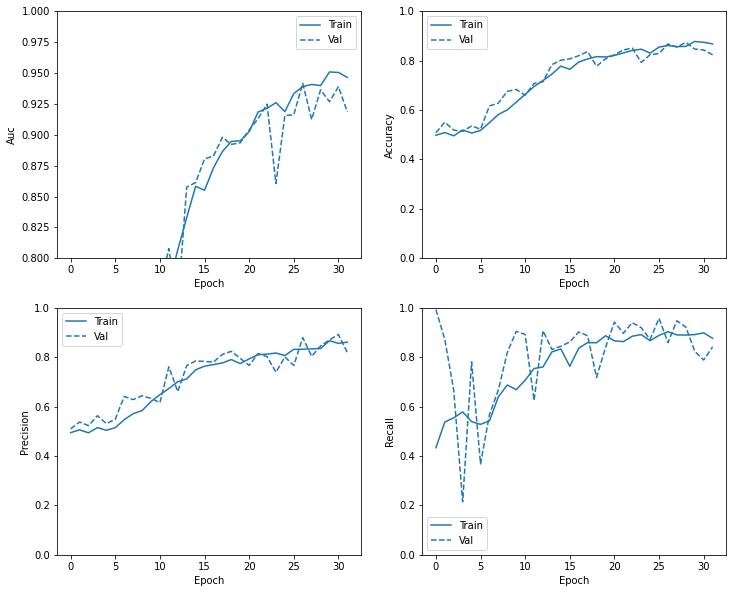

In [84]:
plot_metrics(resampled_history)

## 5. Export the model

In [96]:
export_path_keras = "NNmodel.h5"
model1.save(export_path_keras)

# load the exported model

# NN_model = tf.keras.models.load_model(
#   export_path_keras, 
#   custom_objects={'KerasLayer': hub.KerasLayer})

# **Part IV** Comparison

The densely connected neural network is chosen from all the models we experimented for its running time and performance on accuracy and auc. The results and the links for other models we tried are shown below.

| Model      |Accuracy| Weighted Accuracy |  AUC    |Train Time|Test time| Link|
| ----------- | ----------- | ------    |------|------|------|------|
| Baseline Model (GBT)      | 0.78|0.70       |  0.79   |7.13 s|0.02 s| [GBT](https://github.com/TZstatsADS/Fall2020-Project3-group5/blob/master/doc/baseline_model_tuned.ipynb)|
| XGBoost   | 0.81|0.72       |  0.83|37.21 s |0.06 s |[XGBoost](https://github.com/TZstatsADS/Fall2020-Project3-group5/blob/master/doc/XGBoost_tuned_2.ipynb)|
| Random Forest | 0.80|0.58 | 0.81 |8.38 s |0.23 s |[Random Forest](https://github.com/TZstatsADS/Fall2020-Project3-group5/blob/master/doc/random_forest.ipynb) |
| SVM |0.66|0.71 |0.79|51.37 s |7.87 s |[SVM](https://github.com/TZstatsADS/Fall2020-Project3-group5/blob/master/doc/SVM.ipynb)|
|Neural Networks|0.81|0.73 | 0.83|110.419 s|0.3 s| [NN](https://github.com/TZstatsADS/Fall2020-Project3-group5/blob/master/doc/Neural_Network_train.ipynb)|
|CNN|0.52| 0.52 | 0.51 |278 s |25 s |[CNN](https://github.com/TZstatsADS/Fall2020-Project3-group5/blob/master/doc/CNN.ipynb)|
|KNN |0.76||0.51|73.33 s|15.2 s|[KNN](https://github.com/TZstatsADS/Fall2020-Project3-group5/blob/master/doc/KNN.ipynb)
|LDA|0.70||0.68|20.34 s||[LDA](https://github.com/TZstatsADS/Fall2020-Project3-group5/blob/master/doc/LDA%20with%20PCA.ipynb)
|LDA with PCA|0.72||0.8|0.02s||[LDA with PCA](https://github.com/TZstatsADS/Fall2020-Project3-group5/blob/master/doc/LDA%20with%20PCA.ipynb)
